In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [36]:
def get_columns_and_types(df):
    print('Types detected:')
    print(df.dtypes.unique())
    return {
        'int': [label for label, dtype in df.dtypes.items() if dtype in [int, np.int64]],
        'float': [label for label, dtype in df.dtypes.items() if dtype in [float, np.float64]],
        'object': [label for label, dtype in df.dtypes.items() if dtype in ['O', 'object']],
    }

def convert_dollars_to_float(s, pattern=r"\$|,"):
    """
    convert money-like strings to floats
    """
    if type(s) is str and re.match(pattern, s):
        # if the input is a str containing '$' and/or ',' try to remove those chars and covert the result to a float
        # if this fails, then there is likely text mixed in (like "$195 this week only!")
        try:
            return float(re.sub(pattern, repl='', string=s))
        except:
            return s
    else:
        # otherwise just return the input
        return s

# Boston Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/boston?resource=download

Possible questions:
- Are there seasonal pattern to the month (or time of time)?
- Is there a seasonal pattern to <time> and location?
- Can we fit a penalized regression model to predict price given <X>?
- Can we show an animated map of Boston, showing average price per zip over time?

In [38]:
boston_listings = pd.read_csv('./data/airbnb_boston/listings.csv', index_col='id')
boston_calendar = pd.read_csv('./data/airbnb_boston/calendar.csv')
boston_reviews = pd.read_csv('./data/airbnb_boston/reviews.csv')

boston_listings = boston_listings.map(convert_dollars_to_float)
boston_calendar = boston_calendar.apply(convert_dollars_to_float)
boston_reviews = boston_reviews.apply(convert_dollars_to_float)

In [39]:
boston_listing_col_types = get_columns_and_types(boston_listings)
boston_listing_col_types

Types detected:
[dtype('O') dtype('int64') dtype('float64')]


{'int': ['scrape_id',
  'host_id',
  'host_listings_count',
  'host_total_listings_count',
  'accommodates',
  'guests_included',
  'minimum_nights',
  'maximum_nights',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'number_of_reviews',
  'calculated_host_listings_count'],
 'float': ['neighbourhood_group_cleansed',
  'latitude',
  'longitude',
  'bathrooms',
  'bedrooms',
  'beds',
  'square_feet',
  'price',
  'weekly_price',
  'monthly_price',
  'security_deposit',
  'cleaning_fee',
  'extra_people',
  'has_availability',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value',
  'license',
  'jurisdiction_names',
  'reviews_per_month'],
 'object': ['listing_url',
  'last_scraped',
  'name',
  'summary',
  'space',
  'description',
  'experiences_offered',
  'neighborhood_overview',
  'notes',
  'transit'

# there are no empty 'price' values, but there are empty weekly_price/monthly_price values
- We can ignore weekly_price/monthly_price and just work with price, or we can estimate the missing values with regression

In [55]:
boston_listings[['price', 'weekly_price', 'monthly_price', 'zipcode']].dropna().groupby('zipcode')

,price,weekly_price,monthly_price,zipcode
id,,,,
6976,65.0,395.0,1350.0,02131
1668313,57.0,350.0,1125.0,02131
5434353,145.0,950.0,3000.0,02131
225979,60.0,350.0,1100.0,02131
7252607,49.0,280.0,950.0,02131
...,...,...,...,...
8704828,69.0,450.0,1800.0,02134
7462268,75.0,395.0,1600.0,02134
7602994,28.0,252.0,900.0,02134


In [41]:
boston_listings['price']

id
12147973    250.0
3075044      65.0
6976         65.0
1436513      75.0
7651065      79.0
            ...  
8373729      69.0
14844274    150.0
14585486    198.0
14603878     65.0
14504422     65.0
Name: price, Length: 3585, dtype: float64

In [42]:
boston_calendar_col_types = get_columns_and_types(boston_calendar)
boston_calendar_col_types

Types detected:
[dtype('int64') dtype('O')]


{'int': ['listing_id'], 'float': [], 'object': ['date', 'available', 'price']}

In [43]:
boston_review_col_types = get_columns_and_types(boston_reviews)
boston_review_col_types

Types detected:
[dtype('int64') dtype('O')]


{'int': ['listing_id', 'id', 'reviewer_id'],
 'float': [],
 'object': ['date', 'reviewer_name', 'comments']}

In [44]:
boston_listings[boston_listing_col_types['int']].sort_index()

,scrape_id,host_id,host_listings_count,host_total_listings_count,accommodates,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count
id,,,,,,,,,,,,,,
3353,20160906204935,4240,6,6,1,1,7,365,0,0,0,249,34,2
5506,20160906204935,8229,7,7,2,2,3,730,14,39,69,344,36,6
6695,20160906204935,8229,7,7,4,2,3,730,3,19,49,324,47,6
6976,20160906204935,16701,1,1,2,1,3,45,19,46,61,319,41,1
8792,20160906204935,26988,12,12,3,0,30,365,0,0,0,248,18,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924831,20160906204935,93820834,1,1,1,1,1,14,6,36,66,66,0,1
14928000,20160906204935,93854106,1,1,1,1,1,1125,30,60,90,365,0,1
14928333,20160906204935,36238029,1,1,2,1,1,1125,11,34,64,339,0,1


In [45]:
boston_listings[boston_listing_col_types['float']].sort_index().dropna(how='all', axis=1)

,latitude,longitude,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,
3353,42.355017,-71.127590,1.0,1.0,1.0,NaN,40.0,400.0,1200.0,100.0,50.0,0.0,90.0,9.0,8.0,9.0,9.0,9.0,9.0,0.38
5506,42.329809,-71.095595,1.0,1.0,1.0,225.0,145.0,980.0,3000.0,NaN,40.0,0.0,91.0,9.0,10.0,10.0,10.0,9.0,10.0,0.40
6695,42.329941,-71.093505,1.0,1.0,2.0,NaN,195.0,NaN,NaN,NaN,70.0,8.0,95.0,9.0,10.0,10.0,10.0,8.0,9.0,0.54
6976,42.292438,-71.135765,1.0,1.0,1.0,NaN,65.0,395.0,1350.0,NaN,NaN,20.0,98.0,10.0,9.0,10.0,10.0,9.0,10.0,0.47
8792,42.358497,-71.062011,1.0,1.0,1.0,NaN,154.0,750.0,2900.0,1000.0,250.0,0.0,91.0,10.0,9.0,10.0,9.0,10.0,10.0,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924831,42.381921,-71.068837,1.0,1.0,1.0,NaN,190.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14928000,42.300476,-71.076970,1.0,1.0,1.0,NaN,55.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14928333,42.337349,-71.048150,1.0,1.0,1.0,NaN,90.0,NaN,NaN,NaN,25.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='square_feet', ylabel='price'>

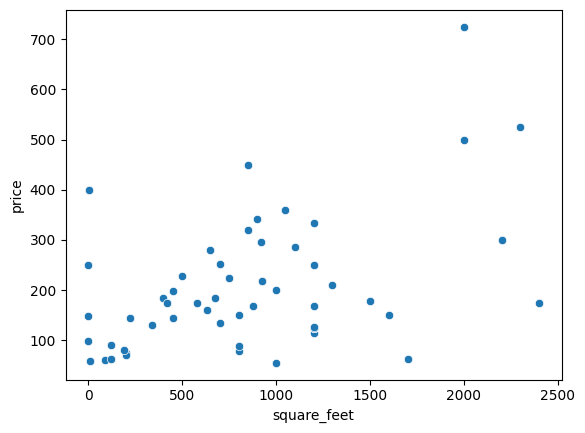

In [54]:
sns.scatterplot(
    data=boston_listings[['price', 'square_feet']].dropna(),
    x='square_feet', y='price')

In [46]:
boston_calendar[boston_calendar.price.isnull()]

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
...,...,...,...,...
1308885,14504422,2016-09-10,f,NaN
1308886,14504422,2016-09-09,f,NaN
1308887,14504422,2016-09-08,f,NaN
1308888,14504422,2016-09-07,f,NaN


In [47]:
boston_calendar[boston_calendar.price.notnull()]

,listing_id,date,available,price
365,3075044,2017-08-22,t,$65.00
366,3075044,2017-08-21,t,$65.00
367,3075044,2017-08-20,t,$65.00
368,3075044,2017-08-19,t,$75.00
369,3075044,2017-08-18,t,$75.00
...,...,...,...,...
1308875,14504422,2016-09-20,t,$62.00
1308876,14504422,2016-09-19,t,$62.00
1308877,14504422,2016-09-18,t,$62.00
1308878,14504422,2016-09-17,t,$62.00


In [48]:
# convert price column to a float, assuming format of $#.#
boston_calendar.price = [float(i.replace('$', '').replace(',', '')) if type(i) is str else i for i in boston_calendar.price]

# concert date to a datetime object
boston_calendar.date = [pd.Timestamp(i) if type(i) is str else i for i in boston_calendar.date]

# add a month, year columns for seasonality analysis
boston_calendar['month'] = [i.month for i in boston_calendar.date]
boston_calendar['year'] = [i.year for i in boston_calendar.date]

<Axes: xlabel='month', ylabel='price'>

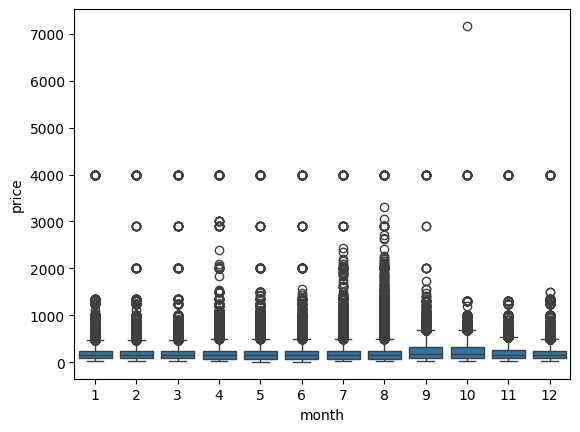

In [49]:
sns.boxplot(
    data=boston_calendar.dropna(),
    x='month',
    y='price',
)

# Seattle Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/seattle/data

In [ ]:
seattle_listings = pd.read_csv('./data/airbnb_seattle/listings.csv', index_col='id')

In [ ]:
seattle_col_types = get_columns_and_types(seattle_listings)

# Stackoverflow Survey Dataset
https://www.kaggle.com/datasets/stackoverflow/so-survey-2017